## This notebook produces the input files for the MOM6 channel simulations of Ong et al. 2024.
https://doi.org/10.1175/JPO-D-23-0067.1

Isopycnals set up so that the CDW layer is thickest

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [28]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':16})
rc('text', usetex=True)
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('axes', titlesize=20)    # fontsize of the axes title
rc('axes', labelsize=20)    # fontsize of the x and y labels

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os

Define basic model configuration parameters.

In [15]:
# Configuration parameters
# (prescribed by user)
#EO: 2021-05-03 uses dimensions mimicking those of Stewart and Thompson (2015)

nlayers = 4    #number of layers

# domain size
Lx = 1000      # domain zonal extent [km]
Ly = 500      # domain meridional extent [km]
H  = 3000  # total fluid's depth in [m]


# bathymetric details
h0 = 2500   # topographic slope height in [m]
#sigh = 50#200  # slope width [km]

#isopycnal layer thickness diff
sigh_rho = 90 # isopycnal slope width [km] #140 dense. 40 warm

gridspacing = 1  # in [km]

# wind stress forcing
tau0 = 0.1 # peak wind stress value [N/m^2] --> 0.025,0.05,0.075,0.1,0.125
sigh_tau = 500  # width of wind stress forcing [km]
tau_offset = 0 # wind offset from the centre of the domain [km]

In [44]:
ninterf = nlayers + 1    #number of interfaces
interfaces = np.arange(0,  ninterf)

nx = round(Lx/gridspacing)
ny = round(Ly/gridspacing)


layerdensities =  [1027.8, 1028.0, 1028.1, 1028.3]  # [kg/m^3]
restintefaceheights = [0.0,-50 , -300, -900]# [m]

In [5]:
sigma_h = 1000
xxx = range(-500,500)
a = 0.1
w = sigma_h *4

In [6]:
def funcsteep(xxx,a,sigma_h):
    ## plotting steep-shaped canyon
    w = sigma_h*4
    func = [0.5*np.sin(((xxx[i]+sigma_h)/w )*2*np.pi)/np.sqrt(np.sin(((xxx[i]+sigma_h)/w) *2*np.pi)**2 + a**2) +0.5 for i in range(1000)]
    for i in range(490 - round(1.75 *sigma_h)):
        func[i] = 0
    for i in range(510 + round(1.75 * sigma_h),1000):
        func[i] = 0
        
    return func

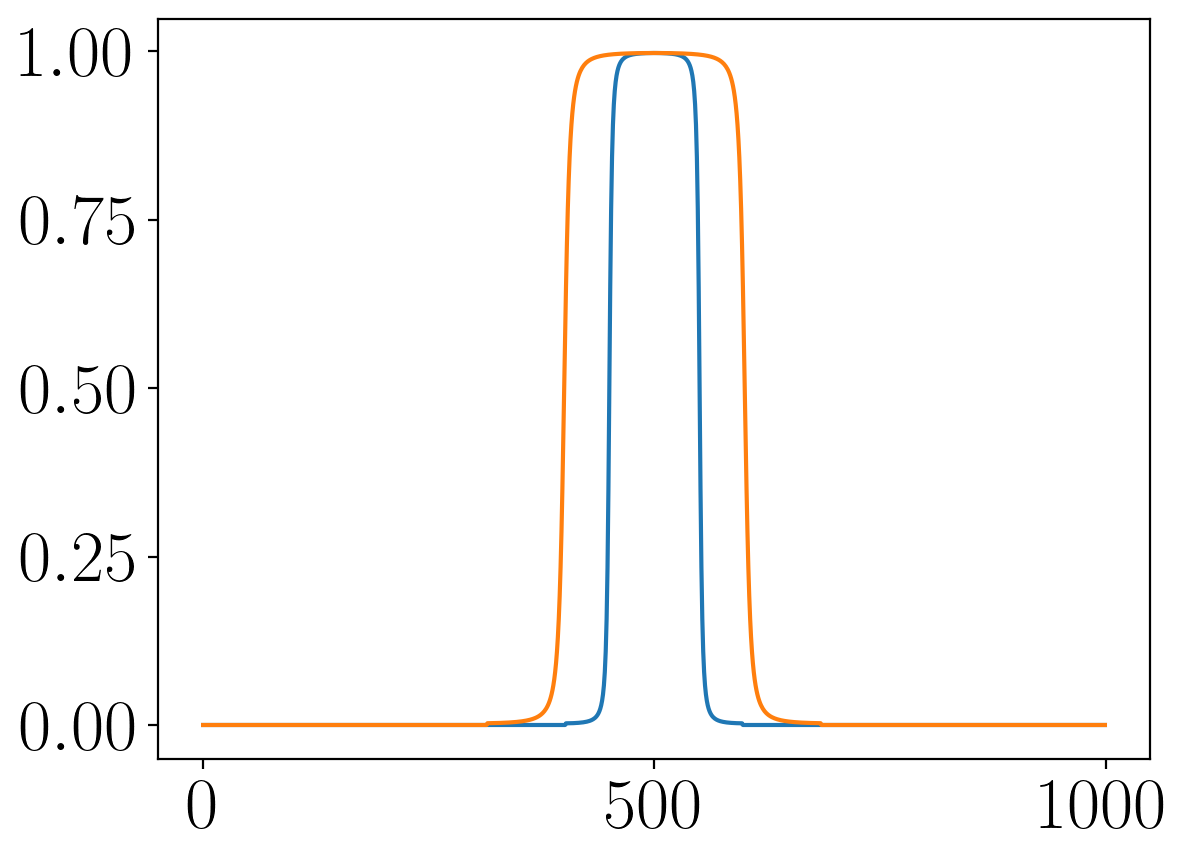

In [7]:
plt.plot(funcsteep(xxx,a,50))
plt.plot(funcsteep(xxx,a,100))

In [11]:
#CONTINOUS CANYON
width_sill = 70 #[m]

x = np.arange(-Lx/2, Lx/2, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)

H = 3000
h0 = 2500 # height of tanh curve for continental slope [m]
sigma_h = 100 # half width of canyon[m]
h0canyon = 400 # depth of canyon [m]
sigma_bottom = 100 # width of tanh continental slope [m] 

hbottom = np.zeros((ny))
bottom = np.zeros((ny, nx))

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)


for leny in np.arange(0,len(y)):
    hbottom[leny] = - (h0/2)*np.tanh(y[leny]/(sigma_bottom/2))
    ## with sill 
    hbottom[leny] = - (h0/2)*np.tanh(y[leny]/(sigma_bottom/2)) *(1-gaussian(leny/width_sill, 0, 1))

#adding steepsided canyon
steep_x = funcsteep(x,a, sigma_h)
for leny in np.arange(0,len(y)):
    for lenx in np.arange(0,len(x)):
        bottom[leny,lenx] = -H + h0/2 + hbottom[leny] - h0canyon * (1 - np.tanh((y[leny])/(sigma_bottom/2)))/2 * steep_x[lenx]

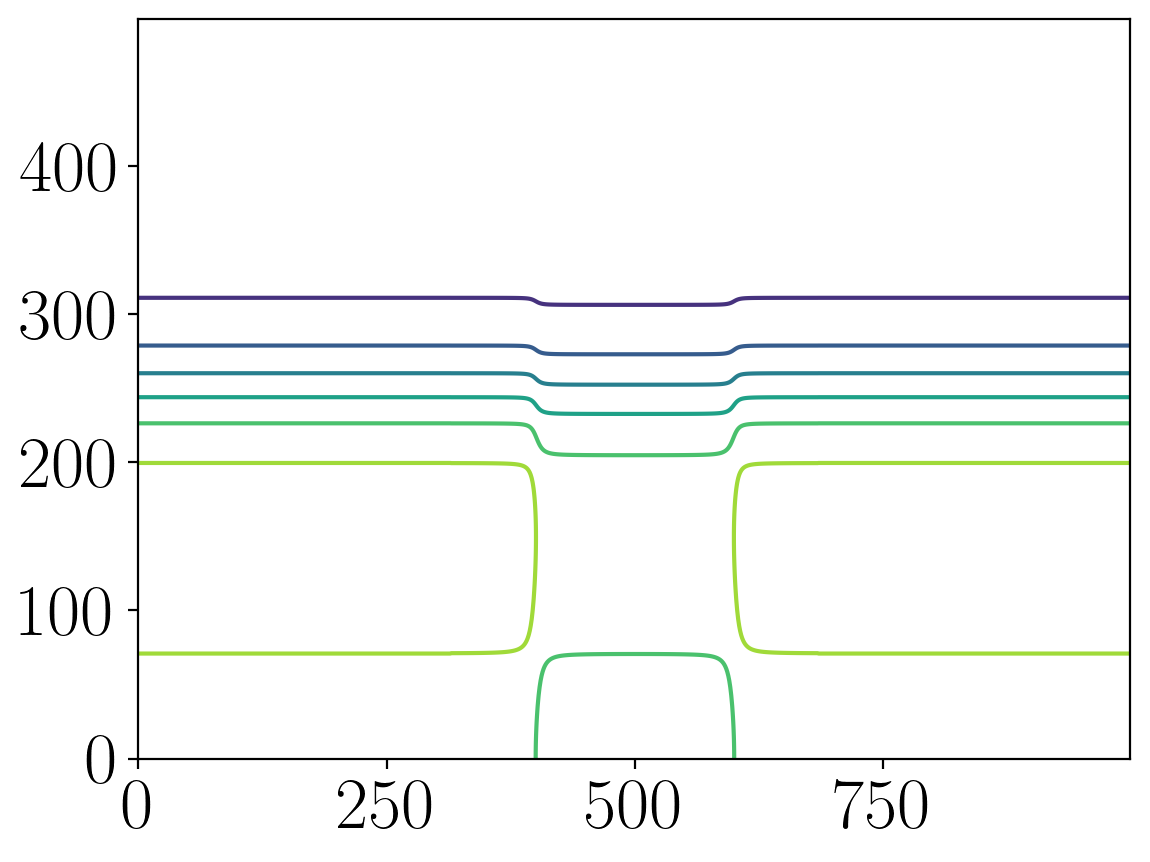

In [9]:
plt.contour(bottom)


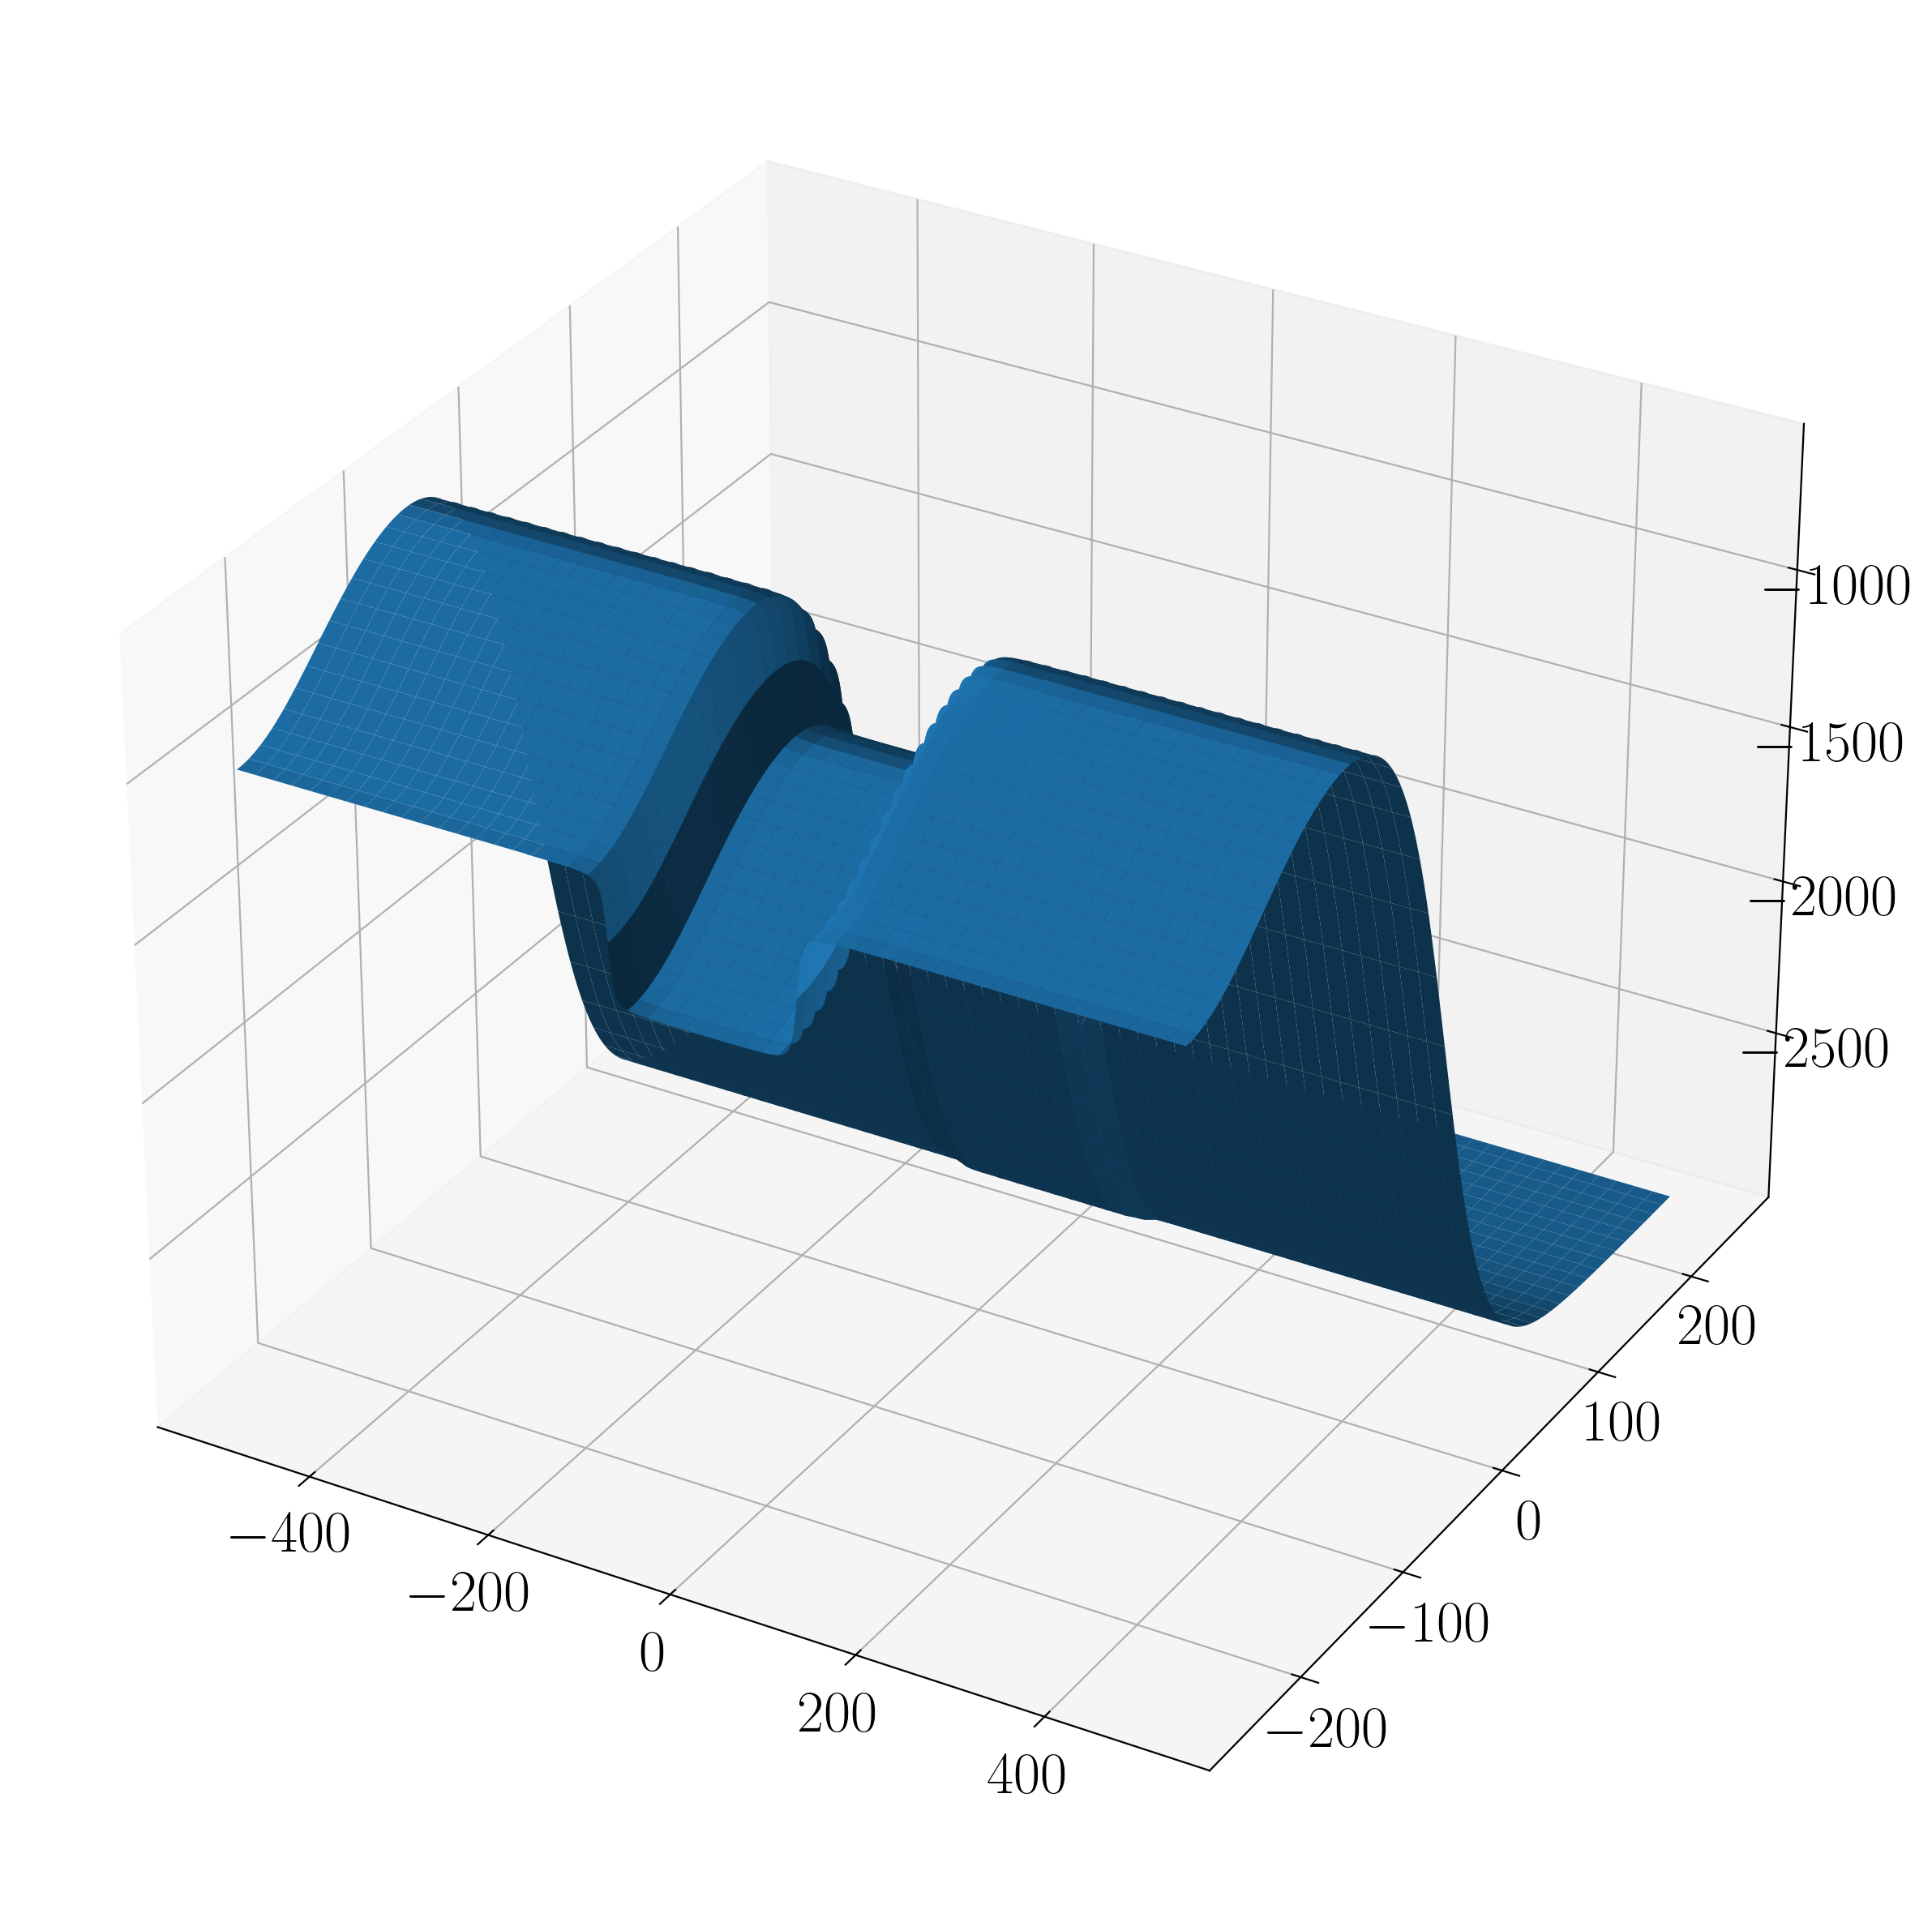

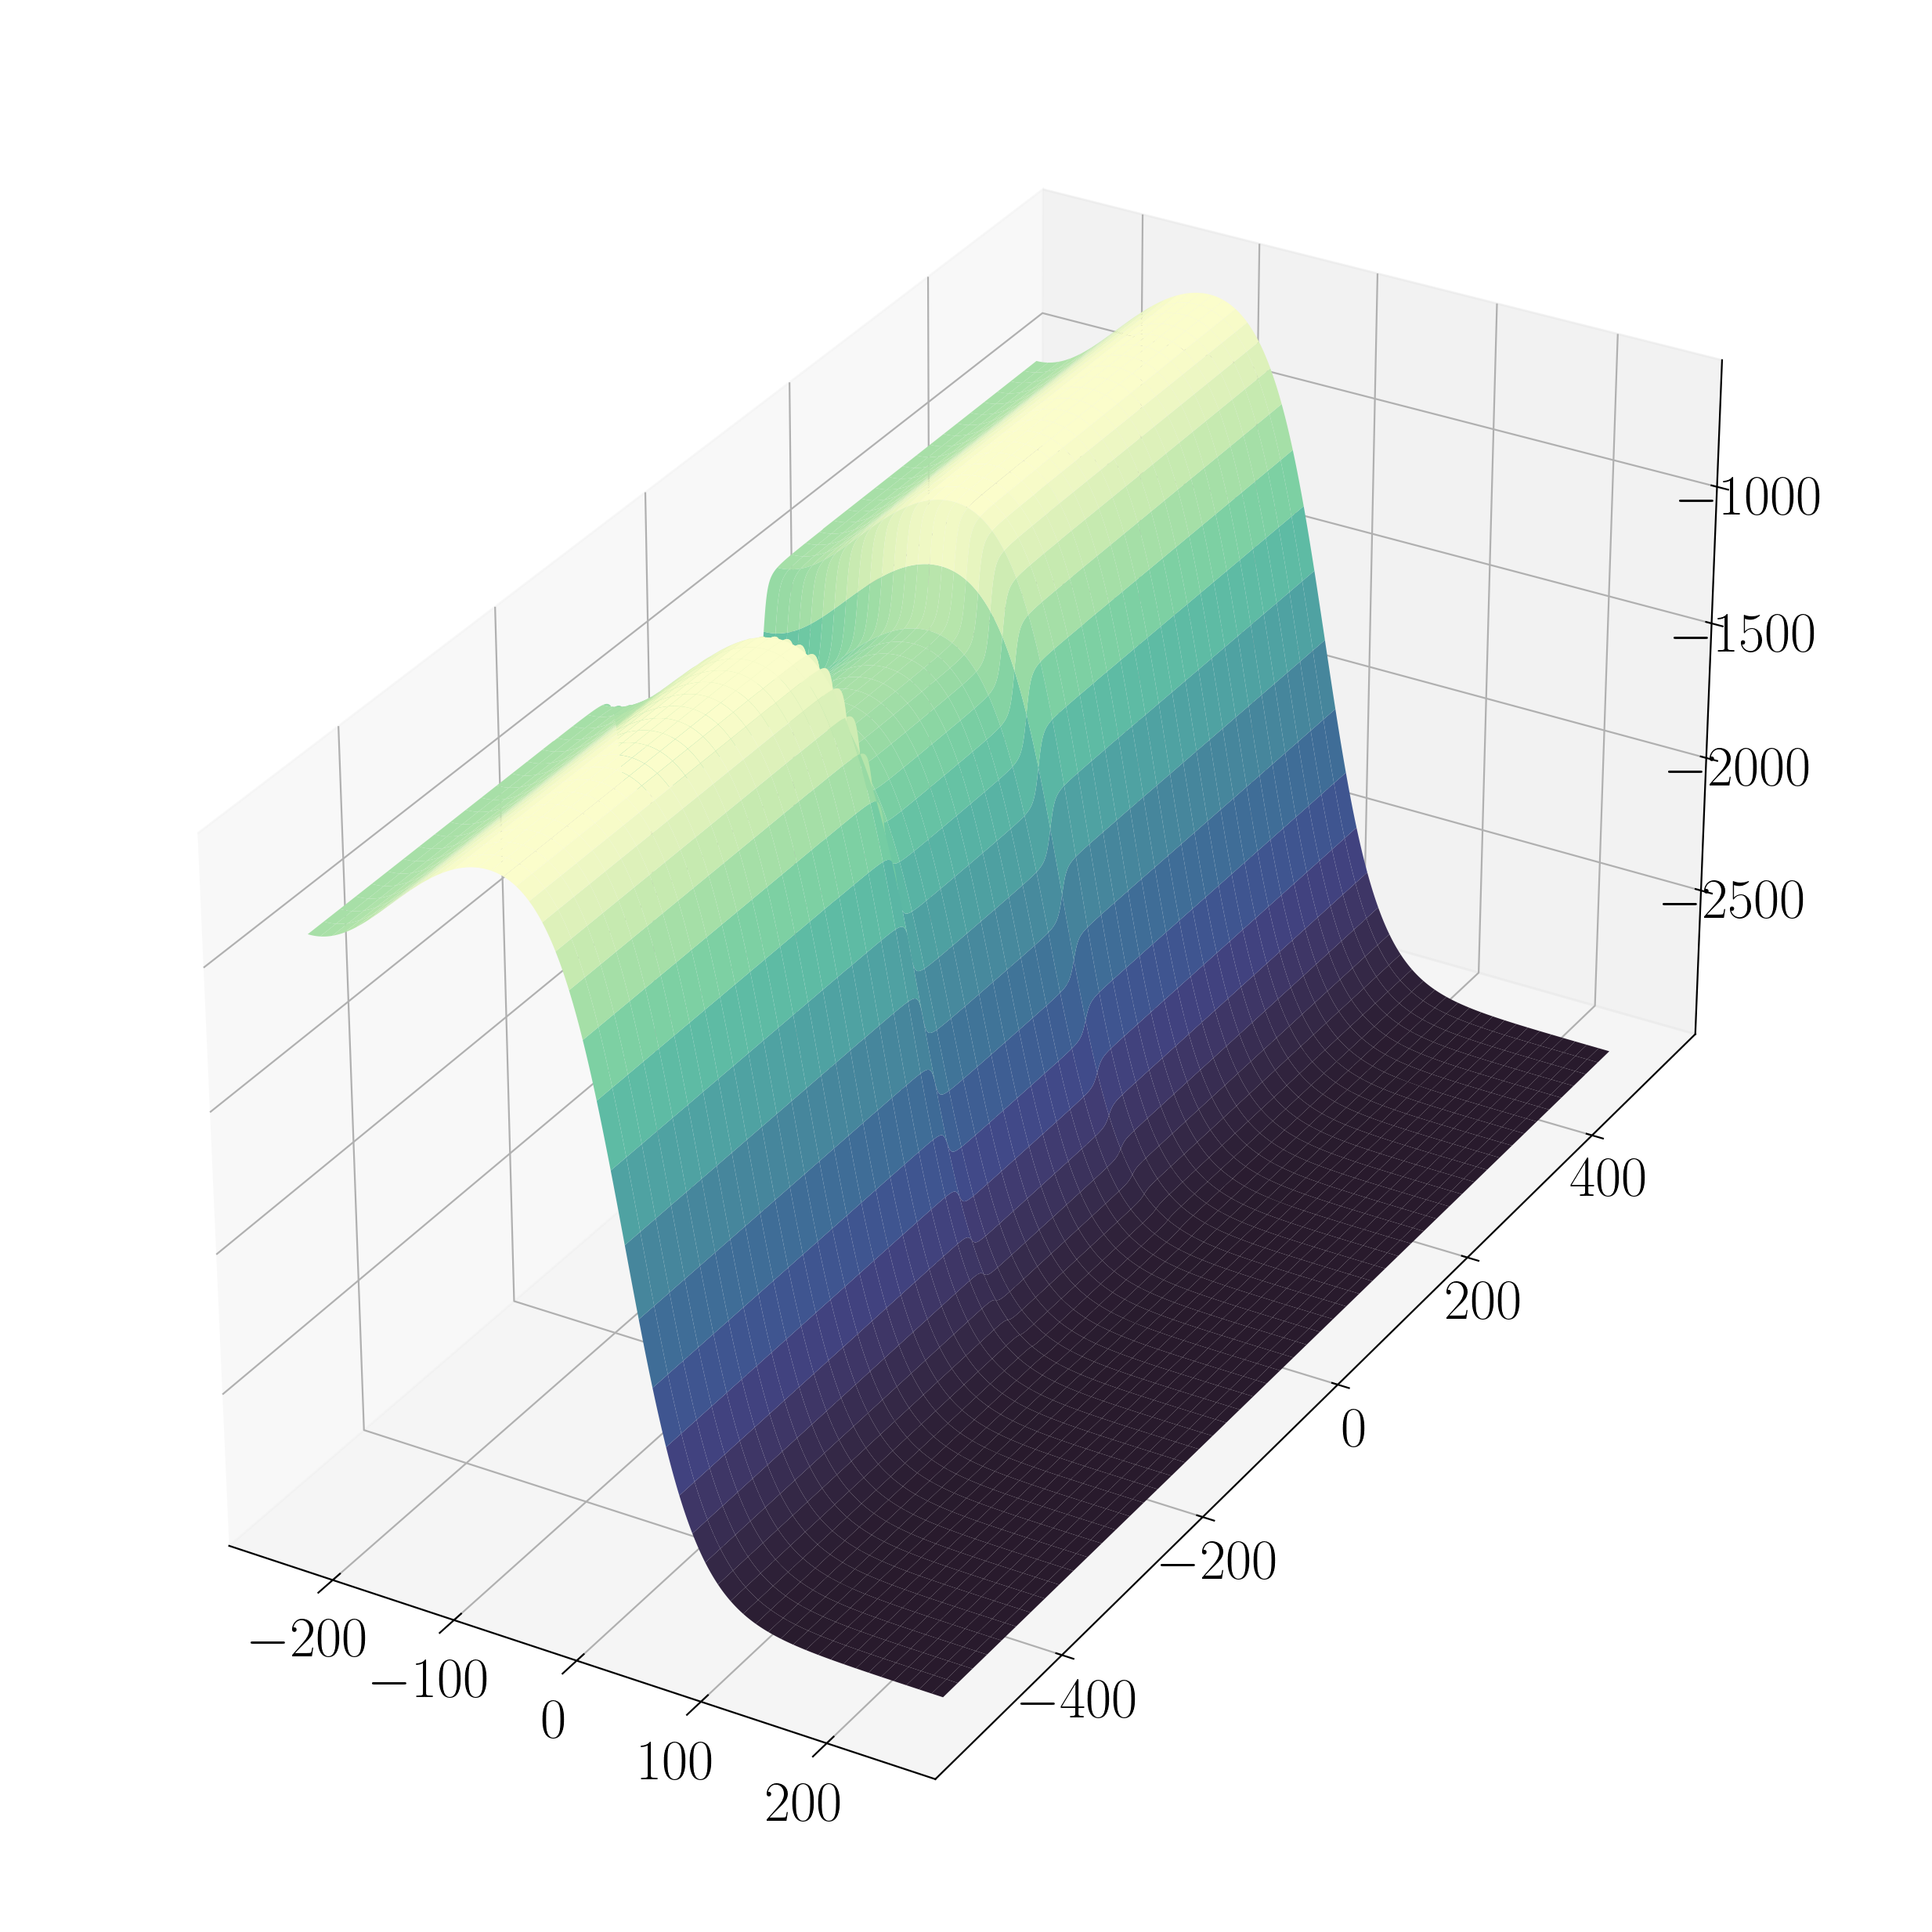

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)

ax.plot_surface(X,Y,bottom)
import cmocean
bathymetry_cmap = cmocean.tools.crop_by_percent(cmocean.cm.topo, 50, which='max', N=None)

fig = plt.figure(figsize = (25,20))
ax = fig.add_subplot(121,projection='3d')
ax.set_box_aspect(aspect = (1,2,1))
ax.plot_surface(np.transpose(Y),np.transpose(X),np.transpose(bottom), cmap  = bathymetry_cmap)
fig.tight_layout()

In [12]:
# prescribing initial interface heights
eta = np.zeros([ninterf, ny, nx])
eta_interf = [0,200, 600,2000]# height of interface at N boundary
h_interf = [0,100, 400,550] # change in interface height throughout domain from N boundary
for j in np.arange(1, nlayers):
    for leny in np.arange(0,len(y)):
        if j == 1:
            eta[j, leny, :] =  -eta_interf[j] + h_interf[j]/2 - (h_interf[j]/2)*np.tanh(y[leny]/(sigh_rho/2))
        if j == 2:            
            eta[j, leny, :] =  -eta_interf[j] + h_interf[j]/2 - (h_interf[j]/2)*np.tanh(y[leny]/(sigh_rho/2))
        if j == 3:
            eta[j, leny, :] =  -eta_interf[j] + h_interf[j]/2 - (h_interf[j]/2)*np.tanh(y[leny]/(sigh_rho/2))
            
eta[nlayers,:,:] = bottom

Create folder to save the input files.

In [25]:
outfolder = '/g/data/v45/qo9901/4layer_input/layer'+str(nlayers)+'_tau'+(str("{:.1e}".format(tau0))).replace('.', 'p')+ '_fresh_STEEPsigmah'+(str("{:.1e}".format(sigma_h))).replace('.', 'p')
outfolder = '/g/data/v45/qo9901/4layer_input/layer'+str(nlayers)+'_tau'+(str("{:.1e}".format(tau0))).replace('.', 'p')+ '_example_STEEPsigmah'+(str("{:.1e}".format(sigma_h))).replace('.', 'p')

if not os.path.exists(outfolder):
    os.makedirs(outfolder)
    
print("Input files will be saved in folder: "+outfolder)

Input files will be saved in folder: /g/data/v45/qo9901/4layer_input/layer4_tau1p0e-01_example_STEEPsigmah1p0e+02


In [17]:
print(eta[1,0,-1])
print(eta[2,0,-1])
print(eta[3,0,-1])
print(eta[3,0,500])

-100.0014945115165
-200.005978046066
-1450.0082198133407
-1450.0082198133407


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'depth [m]')

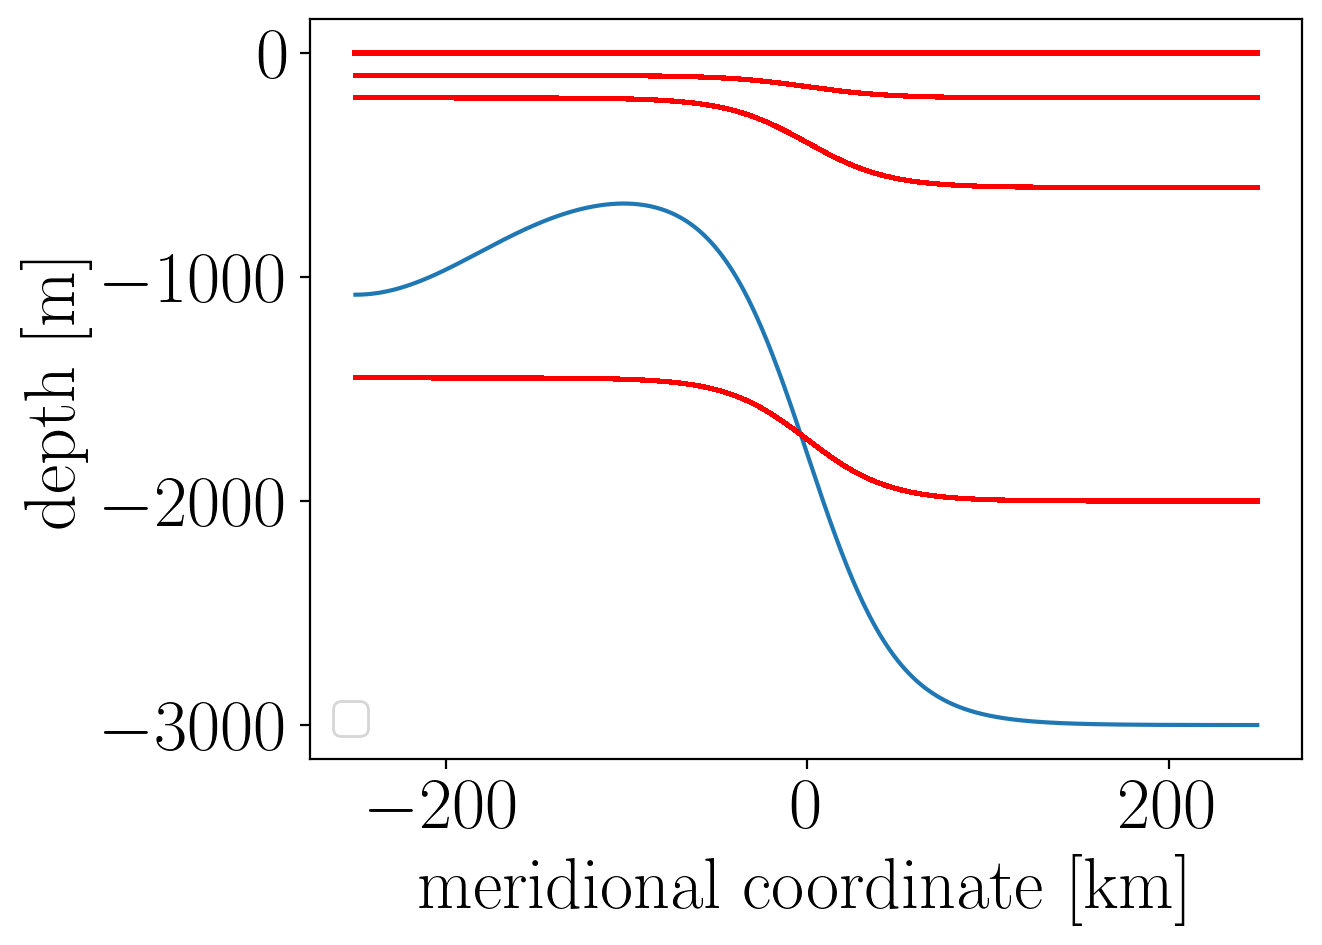

In [18]:
plt.figure()
plt.plot(y,np.mean(eta[nlayers],axis = 1))
for i in range(len(restintefaceheights)):
    #if restintefaceheights[i] > np.mean(eta[nlayers],axis = 1):
        plt.plot(y,eta[i],'r')
plt.legend()
plt.xlabel('meridional coordinate [km]')
plt.ylabel('depth [m]')

Text(0, 0.5, 'depth [m]')

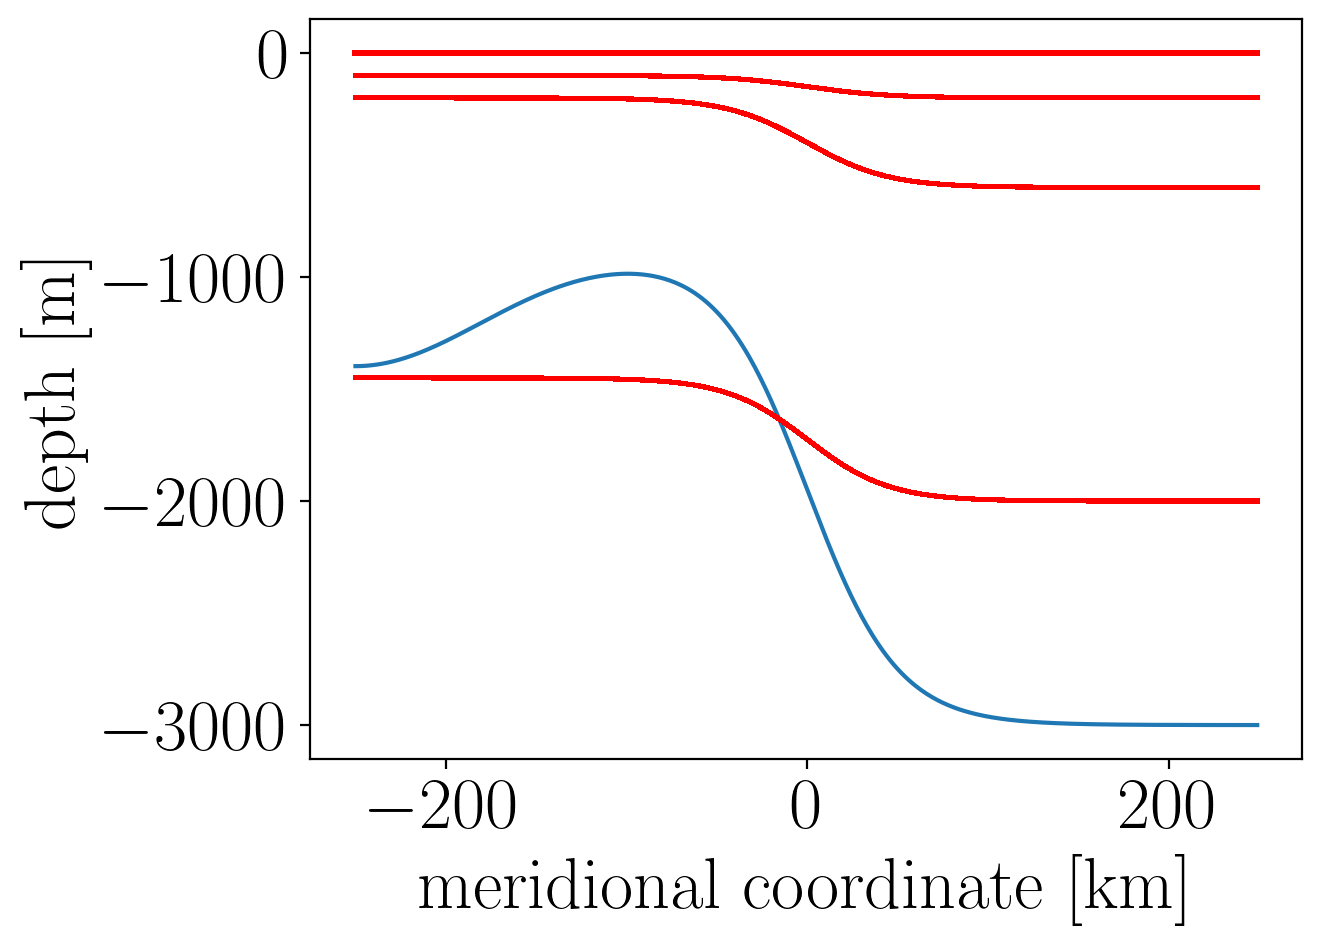

In [19]:
#middle of canyon plot
plt.figure()
plt.plot(y,eta[nlayers,:,500])
for i in range(len(restintefaceheights)):
    #if restintefaceheights[i] > np.mean(eta[nlayers],axis = 1):
        plt.plot(y,eta[i],'r')
plt.xlabel('meridional coordinate [km]')
plt.ylabel('depth [m]')

In [20]:
# wind stress
STRESS_X = np.zeros([ny, nx])
STRESS_Y = np.zeros([ny, nx])

STRESS_X = -tau0*np.cos(np.pi*((Y/sigh_tau-tau_offset/Ly)))**2
STRESS_X[Y<=-Ly/2+tau_offset] = 0

for yy in range(len(Y)):
    if Y[yy,0] > tau_offset:
        STRESS_X[yy,:] = -tau0*np.sin(np.pi*((Y[yy]-250)/(2*(250-tau_offset))))**2 #

Plot the bathymetry and wind stress profile

Text(0, 0.5, 'meridional coordinate [km]')

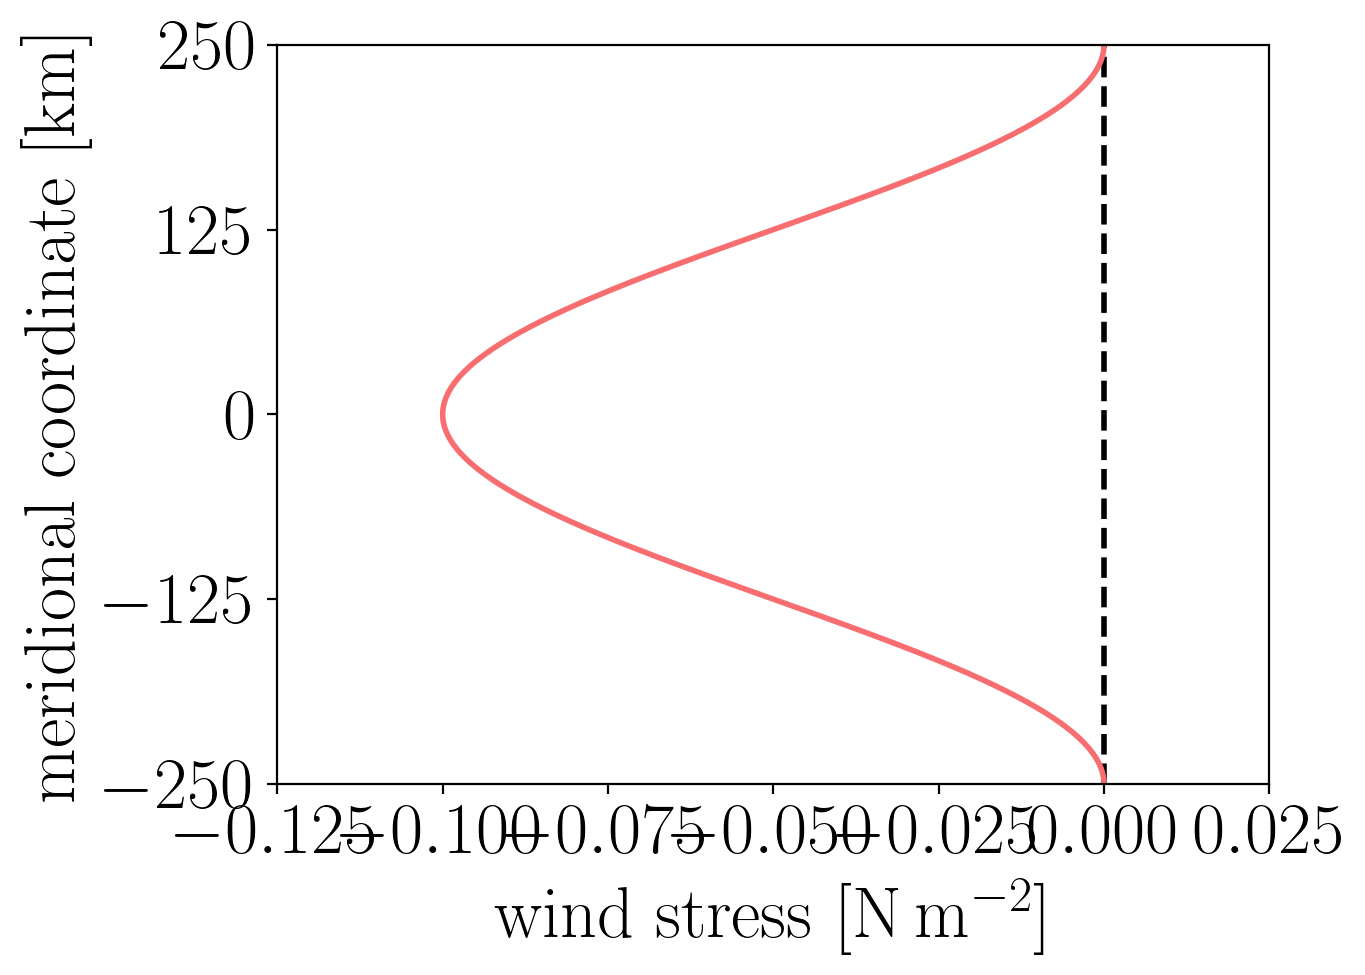

In [21]:
plt.figure()
plt.plot(0*STRESS_X[:,0], y,'--k', label='0.0', lw=2)
plt.plot(1*STRESS_X[:,0], y,'#F86D70', label='0.05', lw=2)
plt.yticks(np.linspace(-Ly/2, Ly/2, 5))
#plt.xticks(np.linspace(-0.25*tau0, 1.25*tau0, 7))
#plt.xlim(-0.25*tau0, 1.25*tau0)
plt.xticks(np.linspace(-1.25*tau0, 0.25*tau0, 7))
plt.xlim(-1.25*tau0, 0.25*tau0)
plt.ylim(-Ly/2, Ly/2)
plt.xlabel('wind stress [N$\,$m$^{-2}$]')
plt.ylabel('meridional coordinate [km]')

In [22]:
np.shape(eta)

(5, 500, 1000)

In [23]:
import numpy as np
import scipy.linalg as la
f0 = -1.3e-4
g = 9.81

Construct the grid, the bathymetry, the rest-fluid interfaces depths, and the wind stress profile.

In [24]:
H

3000

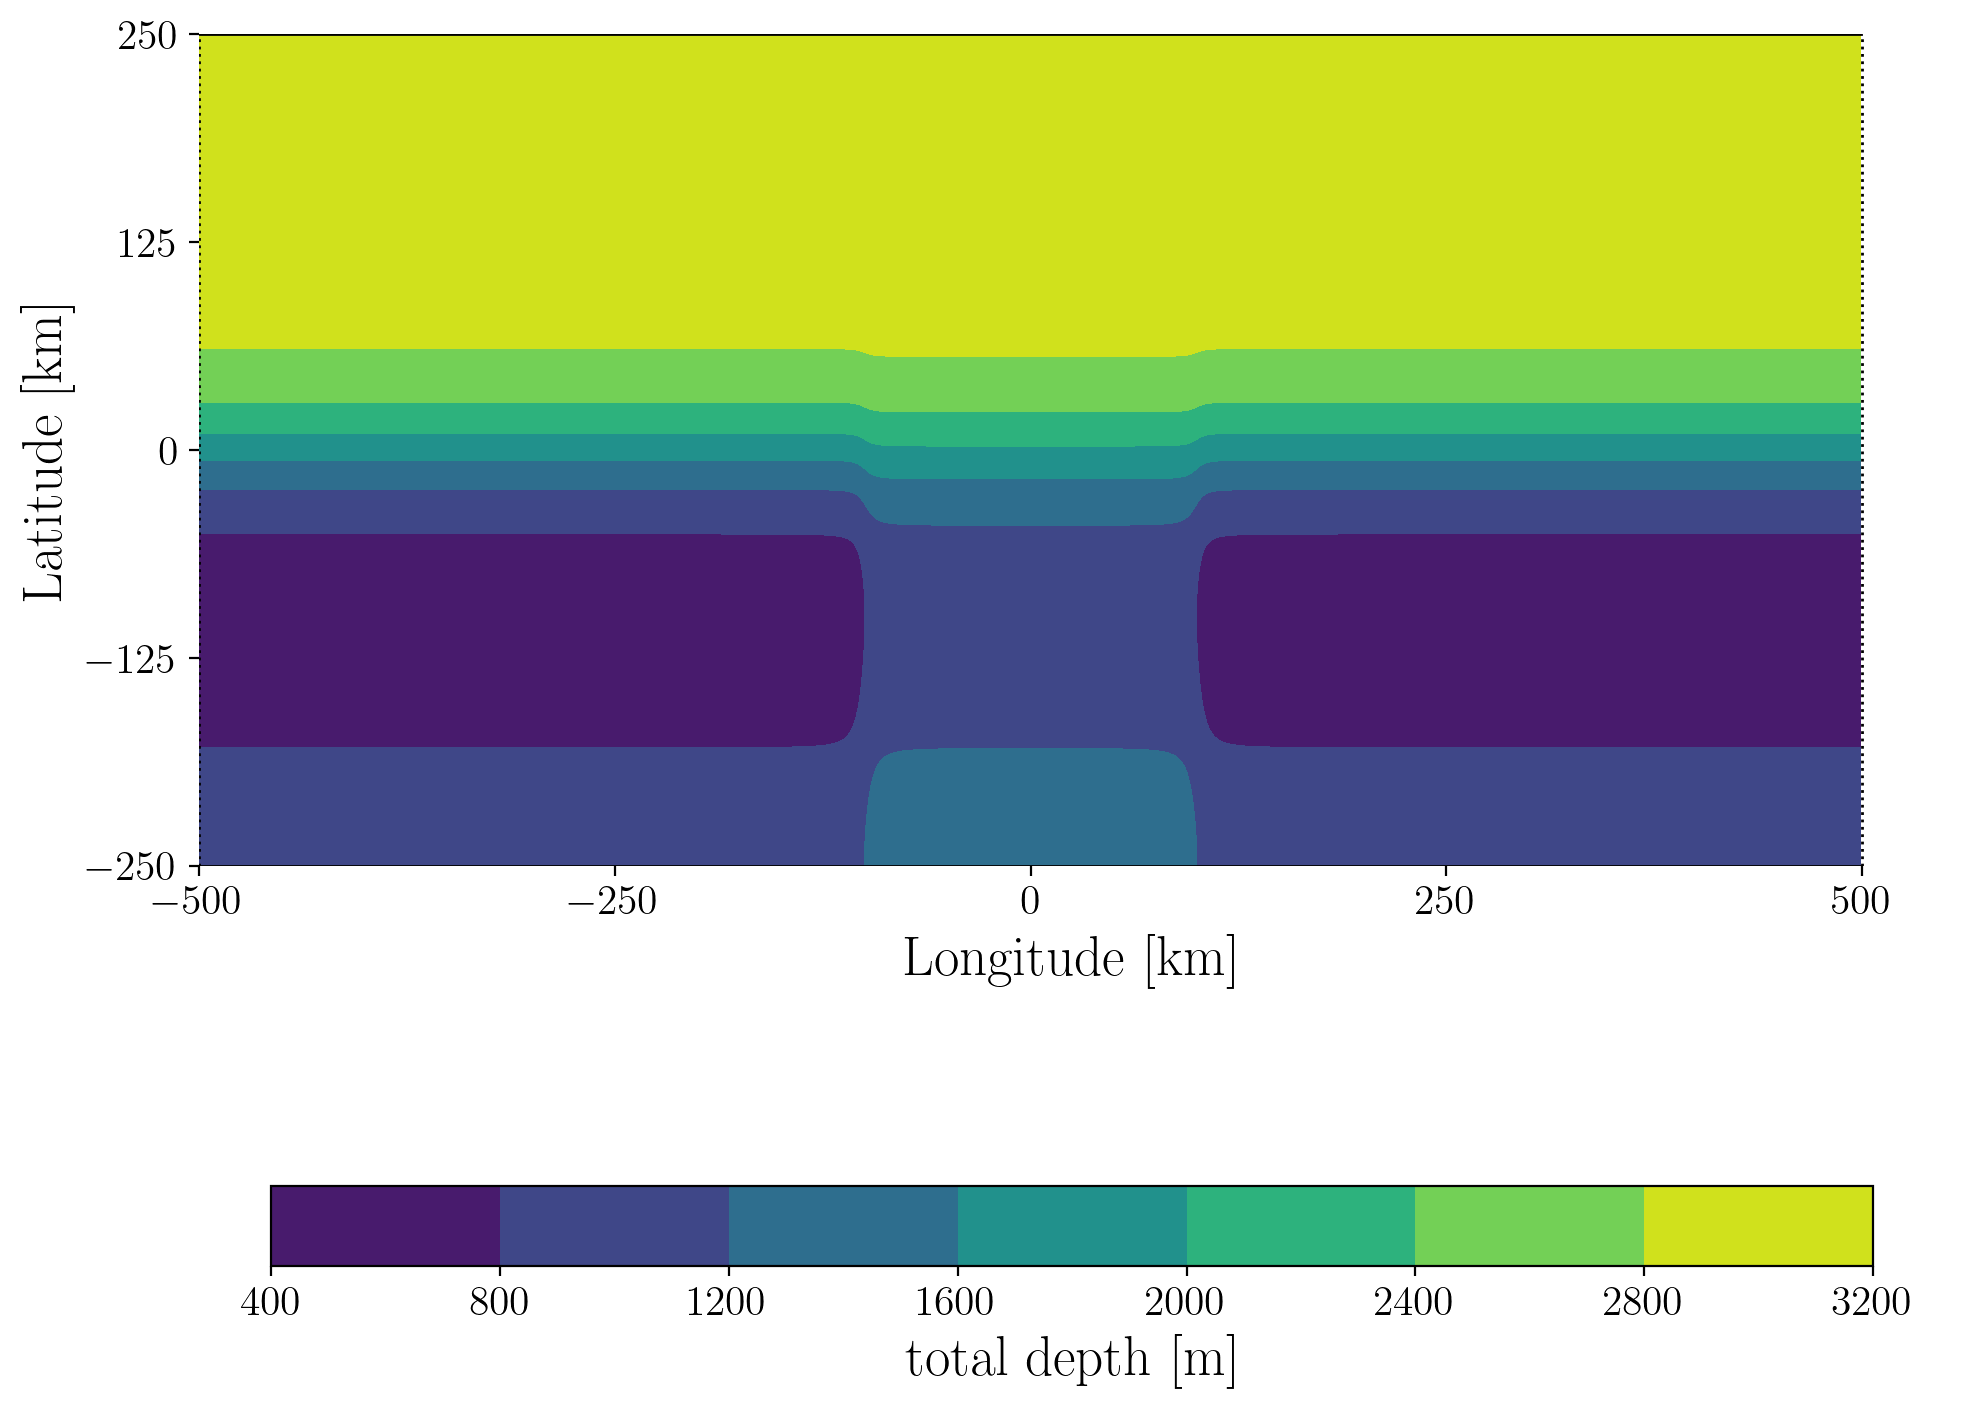

In [29]:
x = np.arange(-Lx/2, Lx/2, gridspacing)
plt.figure(figsize = (15,8))
ax = plt.axes()
ax.set_aspect(1)
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude [km]')
plt.contourf(x, y, -eta[nlayers])

plt.xticks(np.linspace(-Lx/2, Lx/2, 5))
plt.yticks(np.linspace(-Ly/2, Ly/2, 5))
c = plt.colorbar(orientation='horizontal', spacing='proportional', fraction=0.065, pad=0.26)#, ticks=np.linspace(0, H, 6))


c.set_label('total depth [m]')
plt.box(False)
plt.plot(x, 0*x-Ly/2, 'k', linewidth=1)
plt.plot(x, 0*x+Ly/2, 'k', linewidth=1)
plt.plot(0*y-Lx/2, y, ':k', linewidth=1)
plt.plot(0*y+Lx/2, y, ':k', linewidth=1)
plt.ylim(-Ly/2, Ly/2)
plt.savefig(outfolder+'/domain.pdf', bbox_inches='tight')


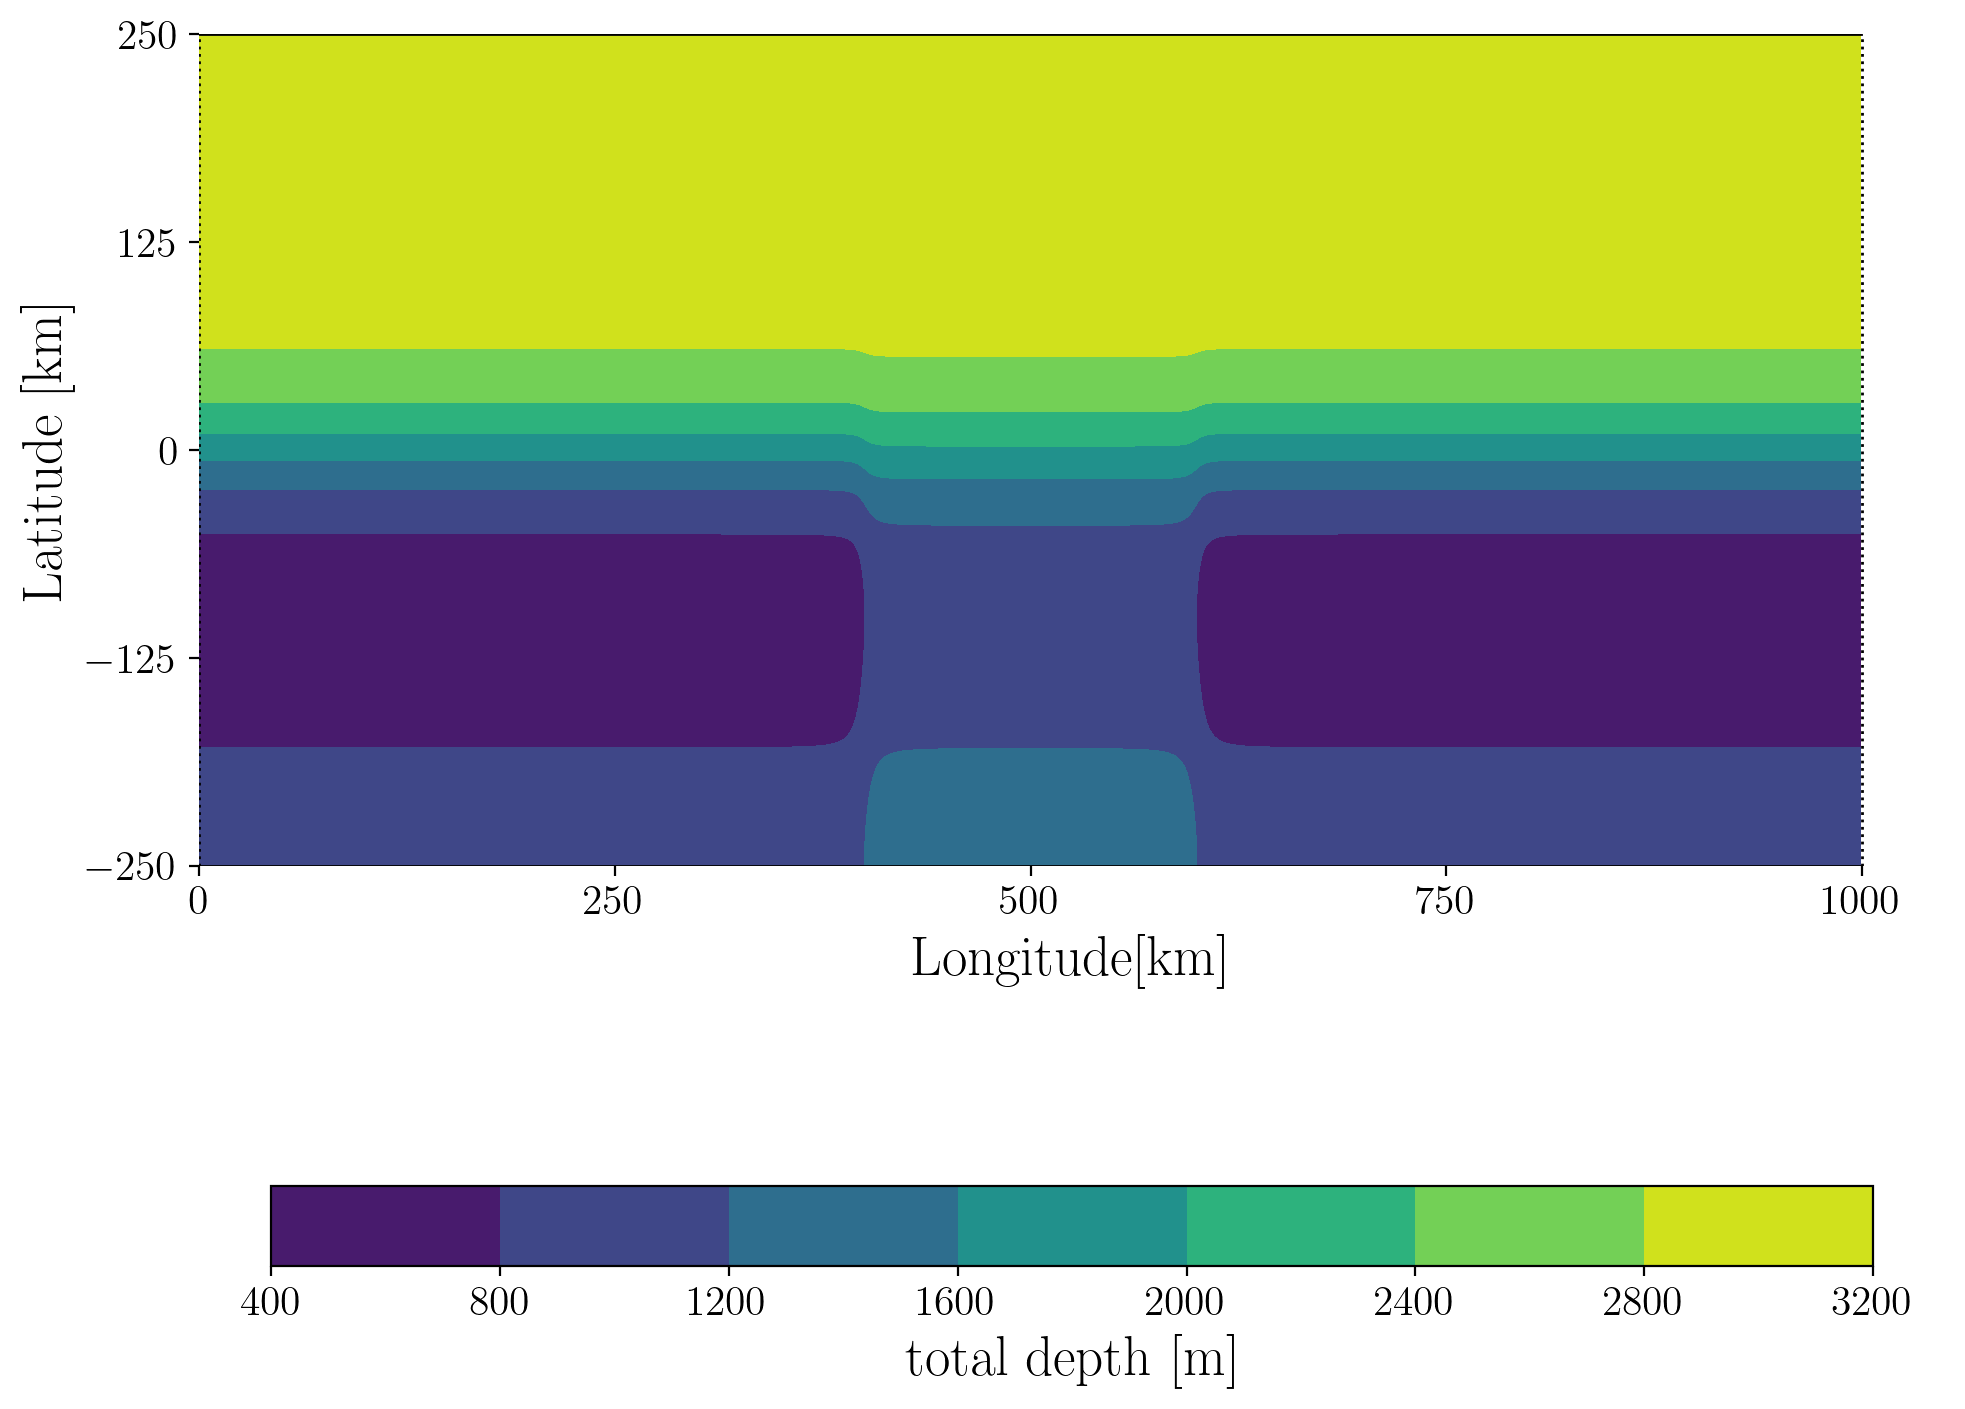

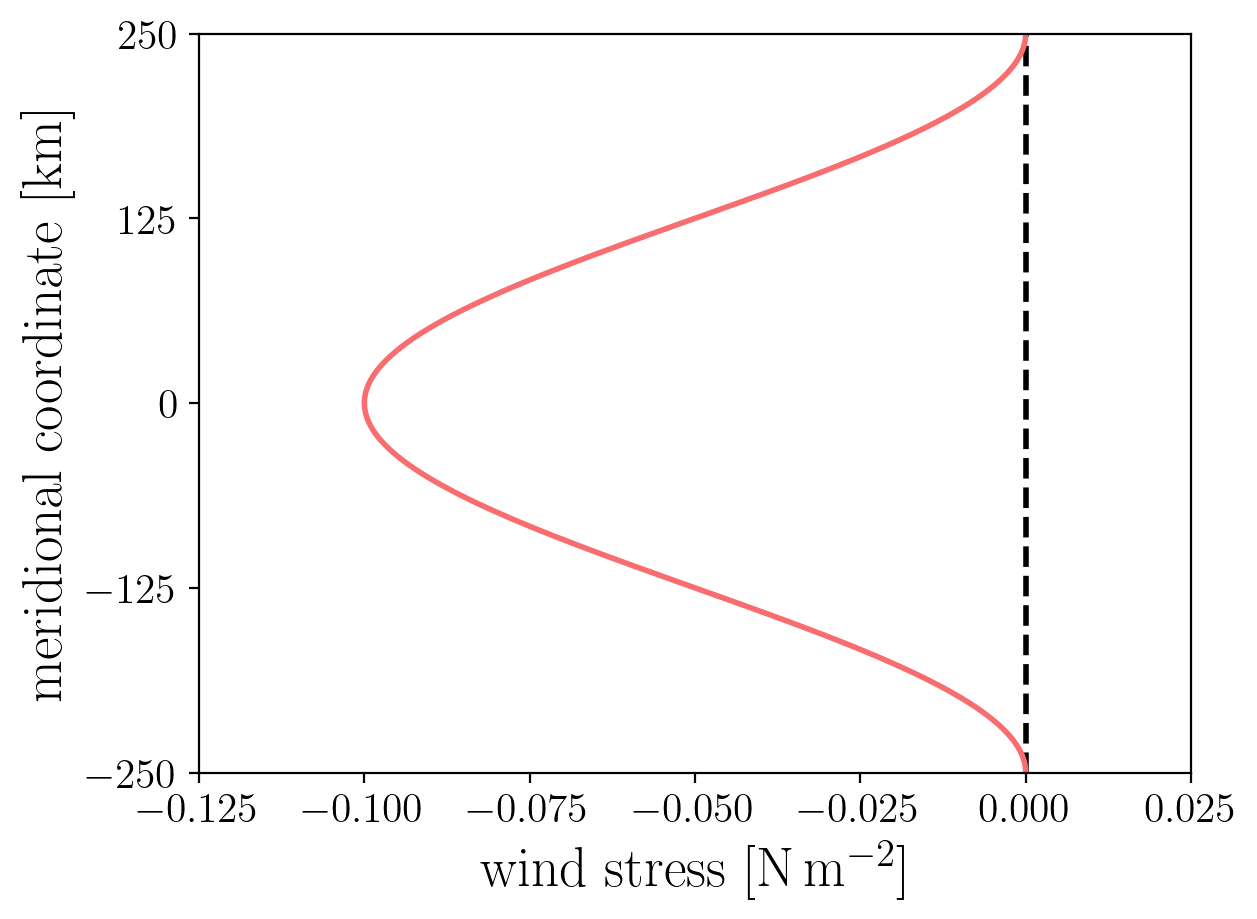

In [30]:
x = np.arange(0, Lx, gridspacing)
plt.figure(figsize = (15,8))
ax = plt.axes()
ax.set_aspect(1)
plt.xlabel('Longitude[km]')
plt.ylabel('Latitude [km]')
plt.contourf(x, y, -eta[nlayers])

plt.xticks(np.linspace(0, Lx, 5))
plt.yticks(np.linspace(-Ly/2, Ly/2, 5))
c = plt.colorbar(orientation='horizontal', spacing='proportional', fraction=0.065, pad=0.26)#, ticks=np.linspace(0, H, 6))


c.set_label('total depth [m]')
plt.box(False)
plt.plot(x, 0*x-Ly/2, 'k', linewidth=1)
plt.plot(x, 0*x+Ly/2, 'k', linewidth=1)
plt.plot(0*y, y, ':k', linewidth=1)
plt.plot(0*y+Lx, y, ':k', linewidth=1)
plt.ylim(-Ly/2, Ly/2)
#plt.savefig(outfolder+'/domain.pdf', bbox_inches='tight')

plt.figure()
plt.plot(0*STRESS_X[:,0], y,'--k', label='0.0', lw=2)
plt.plot(1*STRESS_X[:,0], y,'#F86D70', label='0.05', lw=2)
plt.yticks(np.linspace(-Ly/2, Ly/2, 5))
plt.xticks(np.linspace(-1.25*tau0, 0.25*tau0, 7))
plt.xlim(-1.25*tau0, 0.25*tau0)
plt.ylim(-Ly/2, Ly/2)
plt.xlabel('wind stress [N$\,$m$^{-2}$]')
plt.ylabel('meridional coordinate [km]')
plt.savefig(outfolder+'/windstress.pdf', bbox_inches='tight')


Save the input fields as netCDF files to be called by MOM6.

In [32]:
driverfilename = outfolder+'/driver-layers-topo-densities.nc'
ncOutput = Dataset(driverfilename, 'w', format='NETCDF4')
ncOutput.createDimension('x', nx)
ncOutput.createDimension('y', ny)
ncOutput.createDimension('Layer', nlayers)
ncOutput.createDimension('interface', ninterf)

ncX = ncOutput.createVariable('x', 'float', ('x',))
ncX[:] = x

ncY = ncOutput.createVariable('y', 'float', ('y',))
ncY[:] = y

ncL = ncOutput.createVariable('Layer', 'float', ('Layer',))
ncL[:] = layerdensities

ncEta = ncOutput.createVariable('eta', 'float', ('interface', 'y', 'x'))
ncEta[:] = eta

ncTopo = ncOutput.createVariable('topo', 'float', ('y', 'x'))
ncTopo[:] = -eta[-1]

ncOutput.close()

windfilename = outfolder+'/windstress.nc'
ncOutput = Dataset(windfilename, 'w',format="NETCDF4")

ncOutput.createDimension('x', nx)
ncOutput.createDimension('y', ny)

ncX = ncOutput.createVariable('x', 'float', ('x', ))
ncX[:] = x

ncY = ncOutput.createVariable('y', 'float', ('y', ))
ncY[:] = y

ncSX = ncOutput.createVariable('STRESS_X', 'float', ('y','x'))
ncSX[:] = STRESS_X

ncSY = ncOutput.createVariable('STRESS_Y', 'float', ('y', 'x'))
ncSY[:] = STRESS_Y

ncOutput.close()

In [33]:
pwd

'/home/561/qo9901/MOM6_3layer'

##  Sponge at northern boundary mimicking open ocean

In [34]:
IDAMP = 1/(60*60*24*30) # one month damping time [s^-1]
print(IDAMP, 1/86400)

3.8580246913580245e-07 1.1574074074074073e-05


In [39]:
delta = 0.05 # percentage of domain over which sponge gradually stops.
sponge = np.zeros([ny, nx])
sponge_reg_perc = 0.075 #percentage of domain with full sponge --> was 0.015 for 3layer_ST2015 exp

for yy in range(ny):
    yy_shift = yy - (0.5-sponge_reg_perc)*ny
    sponge[yy,:] = IDAMP * (0.5*(1 + np.tanh((yy_shift -0.5*ny)/(delta*0.5*ny)))) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'depth [m]')

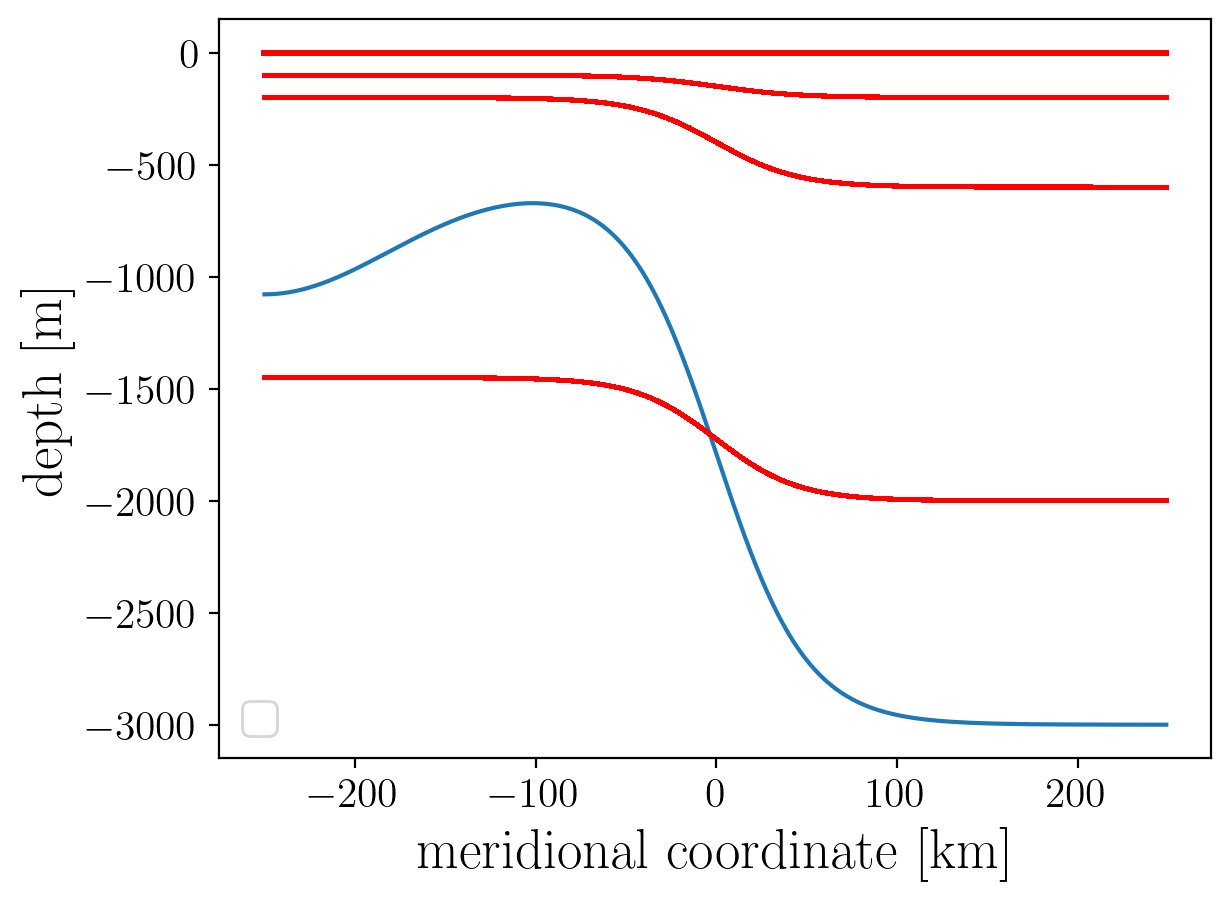

In [36]:
#height at which sponge restores interface to in sponging region
eta_sponge = eta[:]
plt.figure()
plt.plot(y,np.mean(eta_sponge[nlayers],axis = 1))
for i in range(len(restintefaceheights)):
    plt.plot(y,eta_sponge[i],'r')
plt.legend()
plt.xlabel('meridional coordinate [km]')
plt.ylabel('depth [m]')

In [37]:
Idamp = sponge
print(np.shape(Idamp))

(500, 1000)


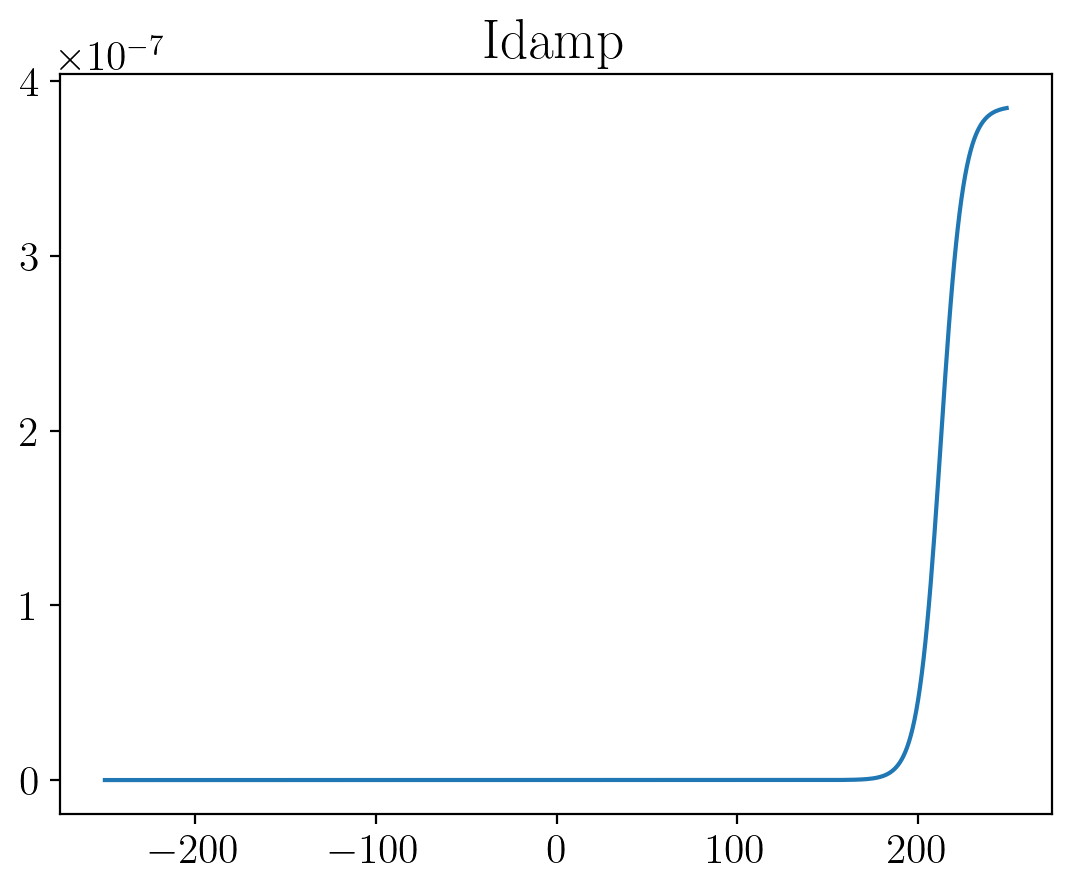

In [40]:
plt.plot(y,np.mean(Idamp,axis = 1))
plt.title('Idamp')
plt.savefig(outfolder + '/Idamp_mean.png')

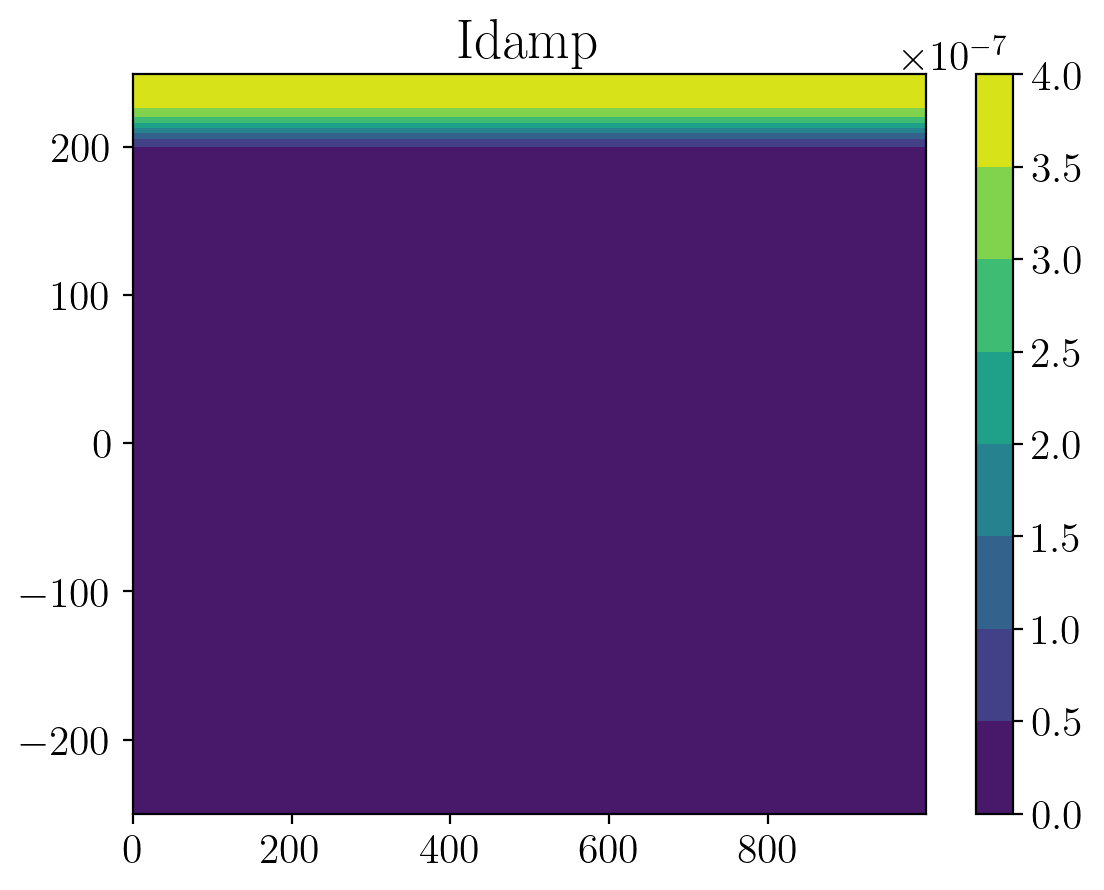

In [41]:
plt.contourf(x,y,Idamp)
plt.colorbar()
plt.title('Idamp')
plt.savefig(outfolder + '/Idamp.png')

In [42]:
spongefilename = outfolder+'/sponge.nc'
ncOutput = Dataset(spongefilename, 'w',format="NETCDF4")

ncOutput.createDimension('x', nx)
ncOutput.createDimension('y', ny)
ncOutput.createDimension('interface', ninterf)

ncX = ncOutput.createVariable('x', 'float', ('x', ))
ncX[:] = x

ncY = ncOutput.createVariable('y', 'float', ('y', ))
ncY[:] = y

ncEta = ncOutput.createVariable('eta', 'float', ('interface', 'y', 'x'))
ncEta[:] = eta_sponge



ncIdamp = ncOutput.createVariable('Idamp', 'float', ('y', 'x'))
ncIdamp[:] = Idamp


ncOutput.close()

In [43]:
outfolder

'/g/data/v45/qo9901/4layer_input/layer4_tau1p0e-01_example_STEEPsigmah1p0e+02'